# Funding secured.

I follow both Elon Musk and Bored Elon Musk on Twitter. Sometimes when I scroll through my timeline I see a tweet from Elon Musk and think, "that's crazy talk". Other times I read a tweet from Bored Elon Musk and think, "this is so crazy it might work".

<img src="elon_tweet.jpg" width="500">

I use the tweepy library to grab tweets for Elon Musk (https://twitter.com/elonmusk) and Bored Elon Musk (https://twitter.com/BoredElonMusk) via the Twitter API. I will then use some classification algorithms to classify the tweets as real or fake.

The first step is to create an app on the Twitter Developer platform in order to generate consumer and access keys. These will allow you to access the Twitter API through tweepy. These keys are specific to your Twitter Developer and/or user account, and so they should be kept private. I generally like to put them in a config.py file and import them. If you put your code on github, you can create a config_example.py file which will show other developers how to set up their config.py file. Also, make sure to add config.py to your .gitignore file.

In [1]:
from config import consumer_key, consumer_secret, access_token, access_token_secret
import tweepy

%matplotlib inline
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()

In [2]:
# Creating the authentication object
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# Setting your access token and secret
auth.set_access_token(access_token, access_token_secret)
# Creating the API object while passing in auth information
api = tweepy.API(auth) 

## Function to grab a user's tweets

Don't you love when you can write a function to keep your code DRY? I know I do.

In [3]:
def get_tweets(listOfTweets, user, numOfTweets):
    # Iterate through all tweets of specific user
    for tweet in tweepy.Cursor(api.user_timeline, id=user).items(numOfTweets):
        # Add tweets in this format
        dict_ = {'Screen Name': tweet.user.screen_name,
                'Tweet Created At': pd.to_datetime(tweet.created_at),
                'Tweet Text': tweet.text,
                }
        listOfTweets.append(dict_)   

## Grab tweets from both accounts

In [7]:
data = []

get_tweets(data, 'BoredElonMusk', 1000)
get_tweets(data, 'elonmusk', 1000)
data_df = pd.DataFrame(data)

In [ ]:
data_df.head()

In [ ]:
data_df.tail()

## Cleaning tweet text

Need to remove 
1. mentions ("@") and retweets ("RT")
2. HTML ("&amp;")
3. links
4. foreign languages (Russian???)
5. hashtags and numbers

In [8]:
# clean tweets 
# https://towardsdatascience.com/another-twitter-sentiment-analysis-bb5b01ebad90
# re.sub('RT @[\w_]+: ', '', tweet)
pat1 ='RT @[\w_]+: '
pat2 = r'@[A-Za-z0-9]+'
pat3 = r'https?://[A-Za-z0-9./]+'
pat4 = r'[^a-zA-Z ]+'
combined_pat = r'|'.join((pat1, pat2, pat3, pat4))

data_df['tweet'] = data_df['Tweet Text']
data_df['tweet'] = data_df.tweet.str.replace(combined_pat, '')
data_df.head()

,Screen Name,Tweet Created At,Tweet Text,tweet
0,BoredElonMusk,2019-06-27 01:11:51,RT @BoredElonMusk: Podiums with built-in stun ...,Podiums with builtin stun guns that go off aft...
1,BoredElonMusk,2019-06-25 04:21:26,Coffee shop that gives you extra strong drinks...,Coffee shop that gives you extra strong drinks...
2,BoredElonMusk,2019-06-19 16:01:04,"Ticketmaster, but not evil.",Ticketmaster but not evil
3,BoredElonMusk,2019-06-08 21:08:51,Blanket that absorbs and transfers heat from o...,Blanket that absorbs and transfers heat from o...
4,BoredElonMusk,2019-06-06 14:52:12,Phone feature that rings your alarm just befor...,Phone feature that rings your alarm just befor...


## Create text features

Uses count vectorizer to do word count in each tweet.

In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer

# vec = CountVectorizer()
# X = vec.fit_transform(data_df['tweet'])

# # inspect in pandas
# words = list(pd.DataFrame(X.toarray(), columns=vec.get_feature_names()))

# with open('words.txt', 'w', encoding="utf-8") as filehandle:  
#     for word in words:
#         filehandle.write('%s\n' % word)

In [ ]:
# # weight word counts by frequency using 
# # term frequency-inverse document frequency (TF–IDF)
# from sklearn.feature_extraction.text import TfidfVectorizer
# vec = TfidfVectorizer()
# X = vec.fit_transform(data_df['tweet'])
# y = data_df['Screen Name']
# pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

# # tf-idf uses idf(t) = log[(1+n)/(1+df(t))] + 1
# # vectors are then normalized by Euclidean norm

In [9]:
# supervised learning example - classification - Gaussian Naive Bayes
from sklearn.model_selection import train_test_split

X = data_df['tweet']
y = data_df['Screen Name']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1991)

In [10]:
# convert content of string into vector of numbers using TF-IDF
# use pipeline to attach vectorized text data to multinomial bayes classifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

In [43]:
# apply model to training data and predict labels for test data
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

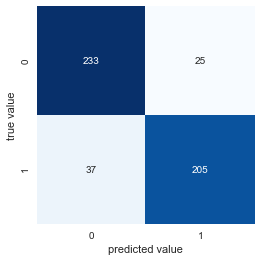

In [93]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

class_names = np.array(['BoredElonMusk', 'elonmusk'])

mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat, square=True, annot=True, cbar=False, cmap='Blues', fmt='g')
plt.xlabel('predicted value')
plt.ylabel('true value');

Confusion matrix, without normalization
[[233  25]
 [ 37 205]]
Normalized confusion matrix
[[0.9  0.1 ]
 [0.15 0.85]]


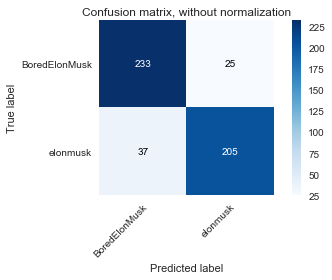

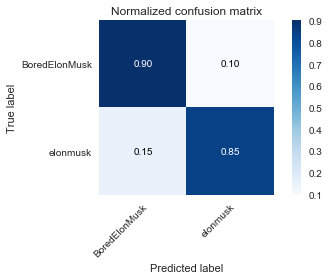

In [94]:
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(ytest, ypred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(ytest, ypred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(ytest, ypred, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.grid(False)

# Plot normalized confusion matrix
plot_confusion_matrix(ytest, ypred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.grid(False)

plt.show()

In [54]:
# see fraction of predicted labels that match their true value
from sklearn.metrics import accuracy_score
accuracy_score(ytest, ypred)

0.876

In [96]:
# check order of labels
# https://stackoverflow.com/questions/50325786/sci-kit-learn-how-to-print-labels-for-confusion-matrix
labels = model.classes_

In [97]:
labels

array(['BoredElonMusk', 'elonmusk'], dtype='<U13')